# Predict Health Outcomes of Horses Preprocessing
Cleaning, data integration, reduction, and transformation for Spaceship Titanic dataset.

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import gc

# Load dataset

In [62]:
train_df = pd.read_csv("train.csv")
train_df.head()

test_df = pd.read_csv("test.csv")

test_ids = test_df['id'].copy()
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

print(f'train shape: {train_df.shape}')
print(f'are there any null values in train: {train_df.isnull().any().any()}\n')

print(f'test shape: {test_df.shape}')
print(f'are there any null values in test: {test_df.isnull().any().any()}\n')

train shape: (1235, 28)
are there any null values in train: True

test shape: (824, 27)
are there any null values in test: True



In [63]:
sum_df = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
sum_df['missing#'] = train_df.isna().sum()
sum_df['missing%'] = train_df.isna().sum() / len(train_df)
sum_df['uniques'] = train_df.nunique().values
sum_df['count'] = train_df.count().values

sum_df.style.background_gradient(cmap='Greens')


,dtypes,missing#,missing%,uniques,count
surgery,object,0,0.000000,2,1235
age,object,0,0.000000,2,1235
hospital_number,int64,0,0.000000,255,1235
rectal_temp,float64,0,0.000000,43,1235
pulse,float64,0,0.000000,50,1235
respiratory_rate,float64,0,0.000000,37,1235
temp_of_extremities,object,39,0.031579,4,1196
peripheral_pulse,object,60,0.048583,4,1175
mucous_membrane,object,21,0.017004,6,1214
capillary_refill_time,object,6,0.004858,3,1229


In [64]:
# Looking for duplicate entries
print(train_df.duplicated().sum())

0


In [65]:
categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time',
                   'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
                   'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']

num_cols = ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
           'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']

target = 'outcome'

# Exploratory Data Analysis
1. Percentage of outcome. 
2. Histogram of continuous features differentiated by outcome
3. Histogram of categorical features differentiated by outcome

Text(0.5, 1.0, 'Outcome Distribution')

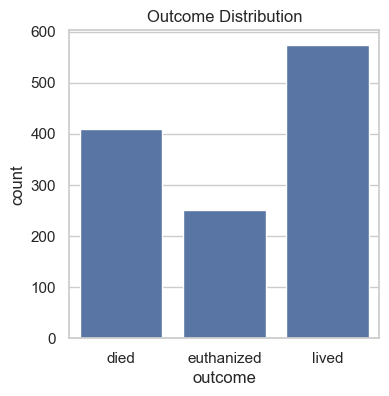

In [66]:
plt.figure(figsize=(4, 4))
sns.countplot(data=train_df, x="outcome")
plt.title("Outcome Distribution")

C:\Users\AHMAD ZAKI\AppData\Local\Temp\ipykernel_11972\4175942637.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')


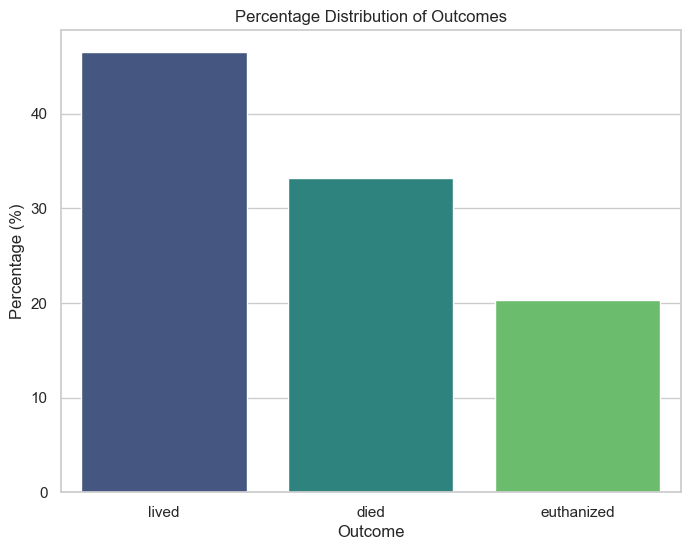

In [67]:
sns.set(style="whitegrid")
outcome_counts = train_df['outcome'].value_counts(normalize=True) * 100  # Convert counts to percentage

plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.title('Percentage Distribution of Outcomes')
plt.ylabel('Percentage (%)')
plt.xlabel('Outcome')
plt.show()

Categorical features

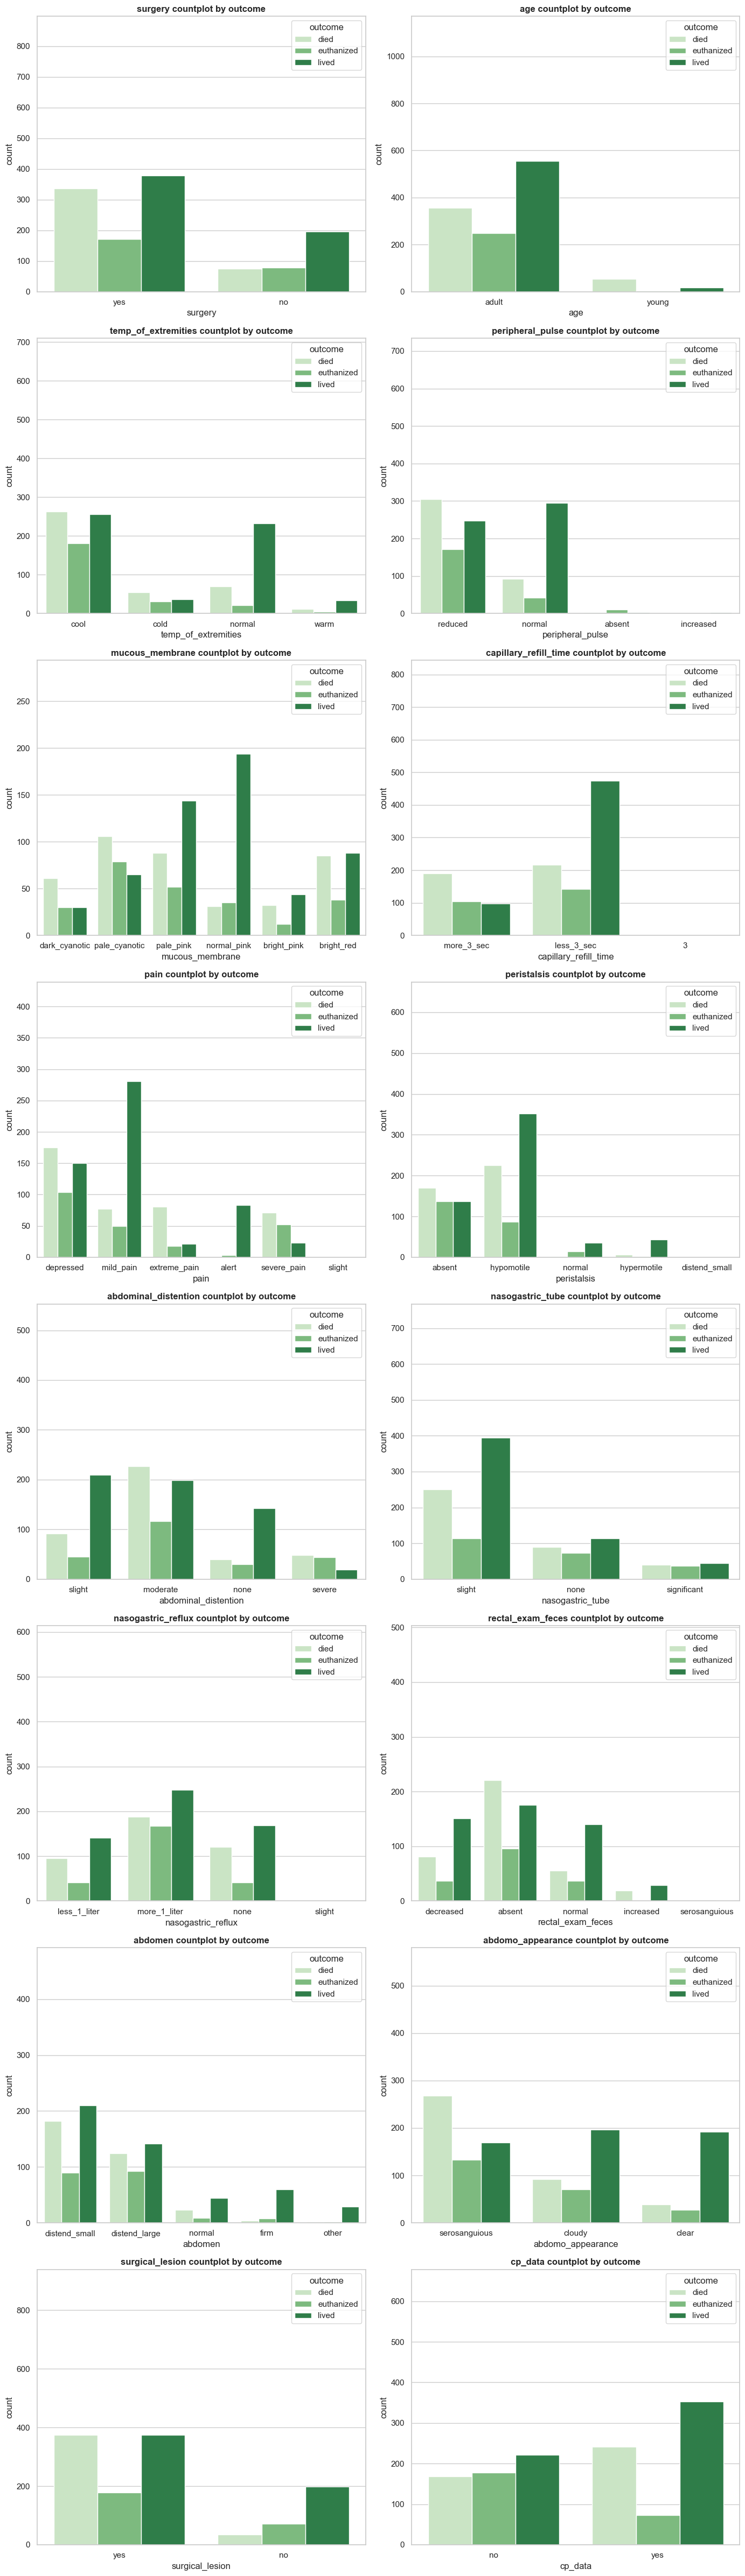

In [68]:
plt.figure(figsize=(14, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):
    
    plt.subplot(len(categorical_cols)//2 + len(categorical_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue="outcome", data=train_df, palette='Greens')
    plt.title(f"{col} countplot by outcome", fontweight = 'bold')
    plt.ylim(0, train_df[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

Continuoes Featuere

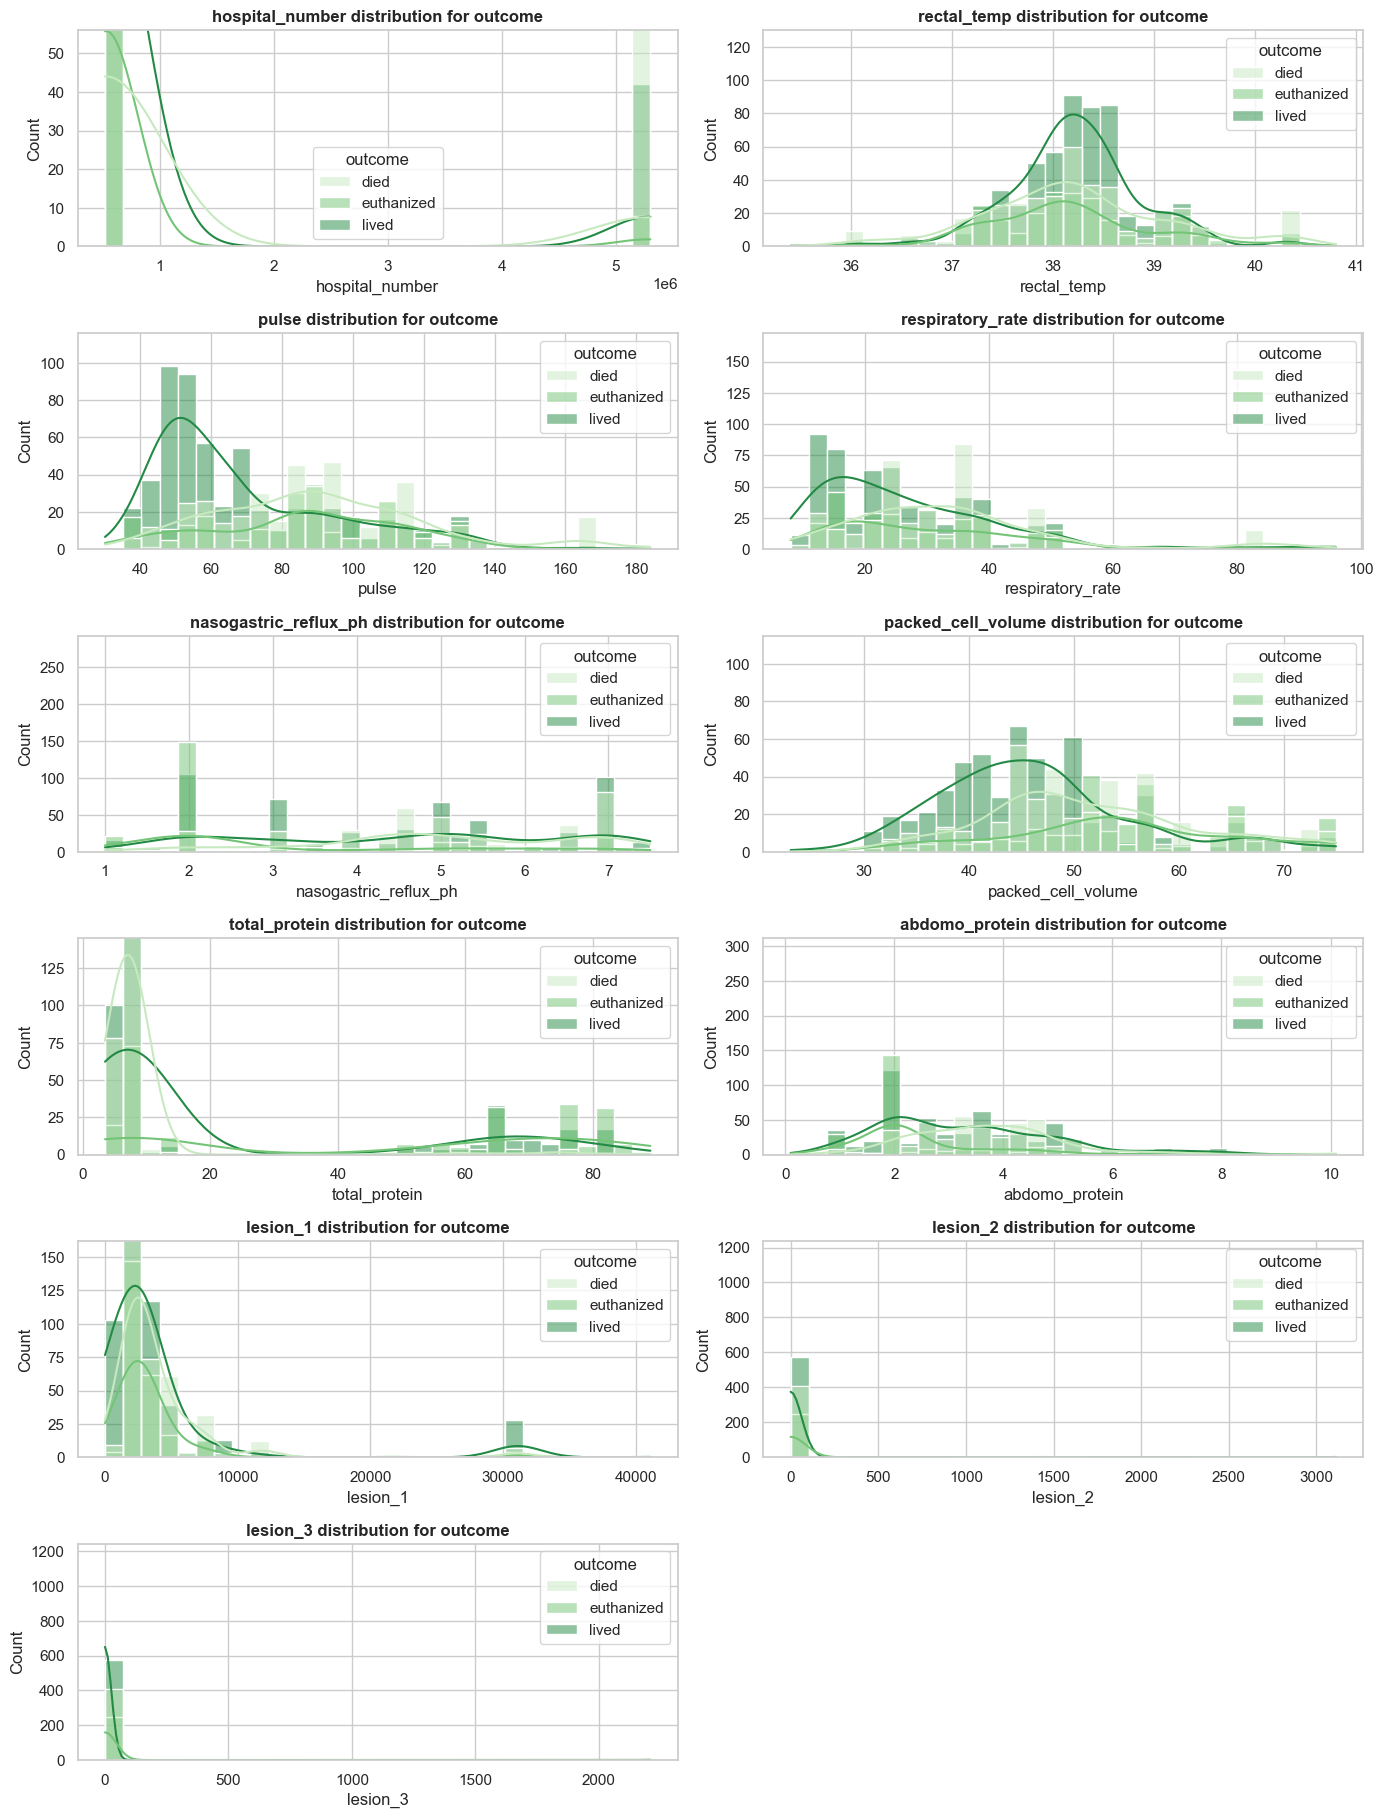

In [69]:
plt.figure(figsize=(14, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue="outcome", data=train_df, bins=30, kde=True, palette='Greens')
    plt.title(f"{col} distribution for outcome", fontweight="bold")
    plt.ylim(0, train_df[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

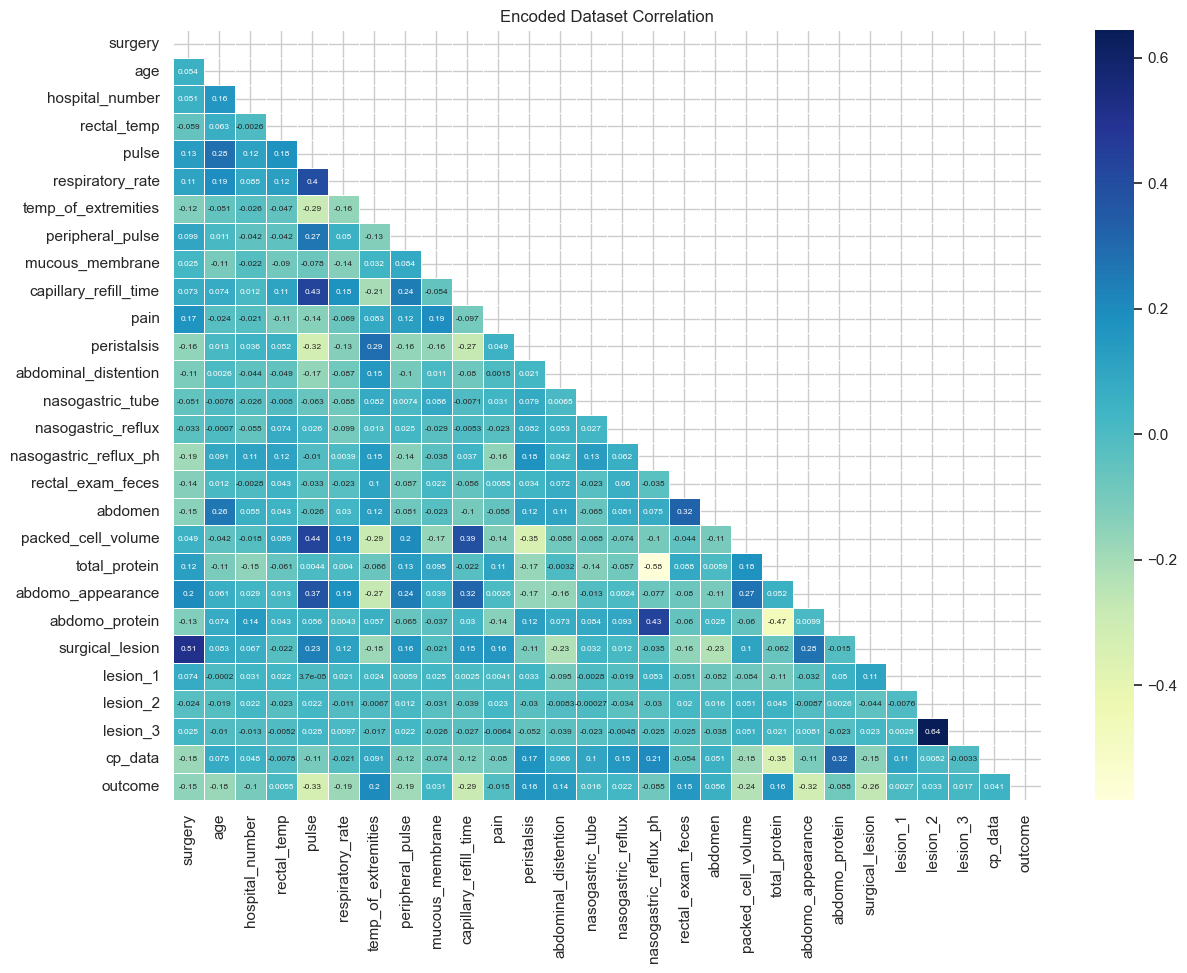

In [70]:
from sklearn.preprocessing import LabelEncoder

df_encoded = train_df.copy()

categorical_vars = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 
                    'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
                    'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 
                    'cp_data', 'outcome']

label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(train_df[column])
    label_encoders[column] = le

excluded_columns = ['id']
columns_without_excluded = [col for col in df_encoded.columns if col not in excluded_columns]
corr = df_encoded[columns_without_excluded].corr()

fig, axes = plt.subplots(figsize=(14, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlGnBu', annot=True, annot_kws={"size": 6})
plt.title('Encoded Dataset Correlation')
plt.show()

Data Preprocessing & Features Engineering

In [71]:
# kolom label encoding dan one hot encoding
le_cols = ["surgery", "age", "surgical_lesion", "cp_data"]
ohe_cols = ["mucous_membrane"]

df = train_df.copy()

le = LabelEncoder()
for col in le_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=ohe_cols)

# ganti nilai 
df["pain"] = df["pain"].replace('slight', 'moderate')
df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')

# handling missing values dan mengubah menjadi numerik
df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2, 'distend_small': 3, 'distend_large': 4})
df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})

df.drop('lesion_3', axis=1, inplace=True)

# feature engineering 
df['lesion_2'] = df['lesion_2'].apply(lambda x: 1 if x > 0 else 0)
df["abs_rectal_temp"] = (df["rectal_temp"] - 37.8).abs()
df.drop(columns=["rectal_temp"], inplace=True)

# simpan hasil preprocessing dan feature engineering ke train_df
train_df = df.copy()

In [72]:
df = test_df.copy()

le = LabelEncoder()
for col in le_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=ohe_cols)

# ganti nilai
df["pain"] = df["pain"].replace('slight', 'moderate')
df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')

# handling missing values dan mengubah menjadi numerik
df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2, 'distend_small': 3, 'distend_large': 4})
df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})

df.drop('lesion_3', axis=1, inplace=True)

# feature engineering
df['lesion_2'] = df['lesion_2'].apply(lambda x: 1 if x > 0 else 0)
df["abs_rectal_temp"] = (df["rectal_temp"] - 37.8).abs()
df.drop(columns=["rectal_temp"], inplace=True)

test_df = df.copy()

In [73]:
print(f'train_df shape: {train_df.shape}')
print(f'are there any null values in train_df: {train_df.isnull().any().any()}\n')

print(f'test_df shape: {test_df.shape}')
print(f'are there any null values in test_df: {test_df.isnull().any().any()}\n')

train_df shape: (1235, 32)
are there any null values in train_df: False

test_df shape: (824, 31)
are there any null values in test_df: False



In [74]:
sum_df = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
sum_df['missing#'] = train_df.isna().sum()
sum_df['missing%'] = train_df.isna().sum() / len(train_df)
sum_df['uniques'] = train_df.nunique().values
sum_df['count'] = train_df.count().values

sum_df.style.background_gradient(cmap='Greens')

,dtypes,missing#,missing%,uniques,count
surgery,int32,0,0.000000,2,1235
age,int32,0,0.000000,2,1235
hospital_number,int64,0,0.000000,255,1235
pulse,float64,0,0.000000,50,1235
respiratory_rate,float64,0,0.000000,37,1235
temp_of_extremities,int64,0,0.000000,4,1235
peripheral_pulse,int64,0,0.000000,4,1235
capillary_refill_time,int64,0,0.000000,3,1235
pain,int64,0,0.000000,6,1235
peristalsis,int64,0,0.000000,4,1235


# Modeling

In [75]:
X_df = train_df.drop(columns=[target])
y_df = train_df[target].map({'died': 0, 'euthanized': 1, 'lived': 2})
X_submission = test_df

In [76]:
print(f'X_df shape: {X_df.shape}')
print(f'y_df shape: {y_df.shape}')
print(f'X_submission shape: {X_submission.shape}')

X_df shape: (1235, 31)
y_df shape: (1235,)
X_submission shape: (824, 31)


In [77]:
classes = np.unique(y_df)  # Get unique class labels
class_to_index = {clas: idx for idx, clas in enumerate(classes)}
y_df_numeric = np.array([class_to_index[clas] for clas in y_df])

class_counts = np.bincount(y_df_numeric)

total_samples = len(y_df_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {clas: weight for clas, weight in zip(classes, class_weights)}

In [91]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

catboost_model = CatBoostClassifier(class_weights=class_weights_dict, random_state=42, verbose=0)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_catboost)
print("Akurasi CatBoost:", accuracy)
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

Akurasi CatBoost: 0.7246963562753036
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67        72
           1       0.82      0.67      0.73        54
           2       0.78      0.74      0.76       121

    accuracy                           0.72       247
   macro avg       0.74      0.72      0.72       247
weighted avg       0.74      0.72      0.73       247



Prediksi

In [95]:
y_submission_pred_catboost = catboost_model.predict(X_submission)

y_submission_pred_catboost = y_submission_pred_catboost.ravel()  # or y_submission_pred_catboost.flatten()

index_to_class = {0: 'died', 1: 'euthanized', 2: 'lived'}
y_submission_pred_original_catboost = [index_to_class[idx] for idx in y_submission_pred_catboost]


In [96]:
print("Hasil prediksi pada X_submission:")
print(y_submission_pred_catboost)

Hasil prediksi pada X_submission:
[2 0 2 1 2 0 0 0 2 2 0 2 2 1 0 2 2 0 0 0 0 0 0 2 0 0 0 1 2 0 2 0 0 2 2 0 0
 2 0 1 0 1 0 1 0 2 0 2 0 0 0 2 0 0 2 2 0 0 0 0 0 0 2 0 0 2 1 0 2 2 0 1 2 2
 1 0 1 0 0 1 0 1 2 1 2 2 2 2 1 2 1 2 0 1 2 1 0 0 0 0 0 2 2 2 2 1 0 0 2 2 0
 0 2 0 2 0 2 0 0 2 0 2 2 2 2 2 0 1 1 2 2 2 2 2 0 2 2 1 0 2 0 0 0 0 0 2 2 1
 0 1 0 0 2 2 0 2 0 2 0 1 2 0 2 0 0 0 0 2 1 2 2 2 2 2 0 2 0 1 2 2 0 2 2 2 0
 0 2 1 2 2 2 2 0 0 2 0 0 2 0 0 0 1 2 2 0 2 2 0 1 2 2 2 0 2 0 1 2 1 1 2 0 1
 1 0 0 1 0 2 0 2 2 2 0 2 1 2 2 0 2 0 2 0 2 2 2 2 0 0 0 0 0 2 0 1 0 0 2 2 2
 2 1 0 1 0 0 1 2 0 2 2 2 0 1 2 2 2 0 0 0 1 0 2 0 0 0 0 2 0 2 0 2 0 0 1 0 0
 2 0 2 0 2 0 2 2 2 2 1 1 1 0 2 2 0 0 2 2 2 2 2 2 2 0 2 1 2 0 0 2 0 2 2 2 2
 0 2 0 0 2 2 2 2 2 0 2 2 0 2 0 2 2 0 1 2 0 1 0 1 2 0 0 2 0 0 0 2 0 0 2 2 2
 0 2 2 0 2 0 1 0 0 2 0 0 2 0 2 2 0 1 0 0 0 0 1 1 1 1 2 0 2 0 1 2 0 0 0 1 1
 2 0 2 1 1 0 0 0 0 1 0 2 1 2 0 0 0 0 0 2 2 2 2 0 1 0 0 2 0 2 2 2 0 0 2 2 0
 1 0 0 0 2 0 1 1 0 0 0 2 2 2 0 2 2 2 0 0 2 2 1 2 0 2 2 0 2 1 2 2 2

In [97]:
submission_dict_cat = {'id': test_ids, 'outcome': y_submission_pred_original_catboost}
submission_df_cat = pd.DataFrame(submission_dict_cat)
submission_df_cat
submission_df_cat.to_csv('CAT_horses_submission.csv', index=False)